In [1]:
import torch
import torch.nn as nn
import pickle
import pandas as pd
from torch import nn, einsum
import numpy as np
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from imblearn.combine import SMOTETomek,SMOTEENN
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, matthews_corrcoef,auc
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

In [2]:
df_train = pd.read_table("/Users/fangzheng/Documents/DSML sem1/DSA5101/Project的副本/traininingdata.txt",sep=';')
df_test = pd.read_table("/Users/fangzheng/Documents/DSML sem1/DSA5101/Project的副本/testdata.txt",sep=';')
print(df_train.shape)
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

distinct_value_counts = [df_train[column].nunique() for column in categorical_columns]

print(distinct_value_counts)
print(df_train.shape)
print(Counter(df_train['y']))

(36168, 17)
[12, 3, 4, 2, 2, 2, 3, 12, 4]
(36168, 17)
Counter({'no': 31937, 'yes': 4231})


Performing the Exploratory Data Analysis


In [3]:
df_train.head().append(df_train.tail())

/var/folders/pn/q7mmpvpx5n36lk_j6p9gqk4c0000gn/T/ipykernel_28241/2757637094.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train.head().append(df_train.tail())


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,42,technician,divorced,secondary,no,-78,yes,yes,cellular,29,jul,10,23,-1,0,unknown,no
1,50,management,married,tertiary,no,106,yes,no,unknown,15,may,388,2,-1,0,unknown,no
2,47,admin.,married,secondary,no,407,yes,no,unknown,5,jun,67,12,-1,0,unknown,no
3,39,admin.,divorced,secondary,no,952,yes,no,unknown,16,jun,62,1,-1,0,unknown,no
4,30,management,single,tertiary,no,364,no,no,cellular,30,apr,306,2,-1,0,unknown,yes
36163,30,management,single,tertiary,no,1243,yes,no,telephone,13,nov,86,1,174,1,failure,no
36164,60,blue-collar,married,secondary,no,171,yes,no,unknown,19,may,219,2,-1,0,unknown,no
36165,41,technician,married,secondary,no,-274,yes,no,unknown,27,may,182,3,-1,0,unknown,no
36166,45,blue-collar,married,primary,no,103,no,no,cellular,28,jan,64,3,-1,0,unknown,no
36167,40,housemaid,married,secondary,no,4136,yes,no,cellular,11,may,508,3,173,5,failure,no


In [4]:
df_train.describe()

,age,balance,day,duration,campaign,pdays,previous
count,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000
mean,40.942076,1365.055989,15.778534,258.363166,2.769907,39.749889,0.579601
std,10.616610,3098.191637,8.313360,257.188052,3.119367,99.547099,2.384831
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1422.250000,21.000000,320.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36168 entries, 0 to 36167
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        36168 non-null  int64 
 1   job        36168 non-null  object
 2   marital    36168 non-null  object
 3   education  36168 non-null  object
 4   default    36168 non-null  object
 5   balance    36168 non-null  int64 
 6   housing    36168 non-null  object
 7   loan       36168 non-null  object
 8   contact    36168 non-null  object
 9   day        36168 non-null  int64 
 10  month      36168 non-null  object
 11  duration   36168 non-null  int64 
 12  campaign   36168 non-null  int64 
 13  pdays      36168 non-null  int64 
 14  previous   36168 non-null  int64 
 15  poutcome   36168 non-null  object
 16  y          36168 non-null  object
dtypes: int64(7), object(10)
memory usage: 4.7+ MB


In [6]:
df_test.head().append(df_test.tail())

/var/folders/pn/q7mmpvpx5n36lk_j6p9gqk4c0000gn/T/ipykernel_28241/3767358655.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test.head().append(df_test.tail())


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,48,housemaid,married,tertiary,no,468,yes,no,unknown,14,may,220,1,-1,0,unknown,no
1,31,management,single,tertiary,no,10215,no,no,cellular,22,aug,139,2,-1,0,unknown,no
2,45,blue-collar,married,primary,no,900,yes,no,unknown,9,jun,213,1,-1,0,unknown,no
3,58,blue-collar,married,primary,no,1231,no,no,unknown,20,jun,21,3,-1,0,unknown,no
4,35,technician,single,tertiary,no,5301,no,no,cellular,21,nov,937,2,-1,0,unknown,yes
9038,27,services,single,secondary,no,1,yes,yes,unknown,2,jun,162,3,-1,0,unknown,no
9039,34,blue-collar,married,secondary,no,175,yes,no,cellular,14,may,50,2,364,2,failure,no
9040,34,blue-collar,married,primary,no,1873,yes,no,cellular,2,feb,192,1,-1,0,unknown,no
9041,37,technician,single,secondary,no,61,yes,no,unknown,19,may,182,8,-1,0,unknown,no
9042,49,blue-collar,married,unknown,no,51,yes,no,unknown,7,may,984,1,-1,0,unknown,no


In [7]:
df_test.describe()

,age,balance,day,duration,campaign,pdays,previous
count,9043.00000,9043.000000,9043.000000,9043.000000,9043.000000,9043.000000,9043.000000
mean,40.91275,1351.137565,15.917948,257.362822,2.739578,41.989384,0.583214
std,10.62792,2821.123124,8.358368,258.894975,3.011181,102.408067,1.944261
min,18.00000,-2282.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.00000,74.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.00000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.00000,1442.500000,22.000000,313.000000,3.000000,-1.000000,0.000000
max,93.00000,81204.000000,31.000000,3785.000000,55.000000,842.000000,55.000000


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9043 entries, 0 to 9042
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        9043 non-null   int64 
 1   job        9043 non-null   object
 2   marital    9043 non-null   object
 3   education  9043 non-null   object
 4   default    9043 non-null   object
 5   balance    9043 non-null   int64 
 6   housing    9043 non-null   object
 7   loan       9043 non-null   object
 8   contact    9043 non-null   object
 9   day        9043 non-null   int64 
 10  month      9043 non-null   object
 11  duration   9043 non-null   int64 
 12  campaign   9043 non-null   int64 
 13  pdays      9043 non-null   int64 
 14  previous   9043 non-null   int64 
 15  poutcome   9043 non-null   object
 16  y          9043 non-null   object
dtypes: int64(7), object(10)
memory usage: 1.2+ MB


###  There are no null values in the table

In [9]:
df_train.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [10]:
df_test.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

### There exist the imbalance data in the training set

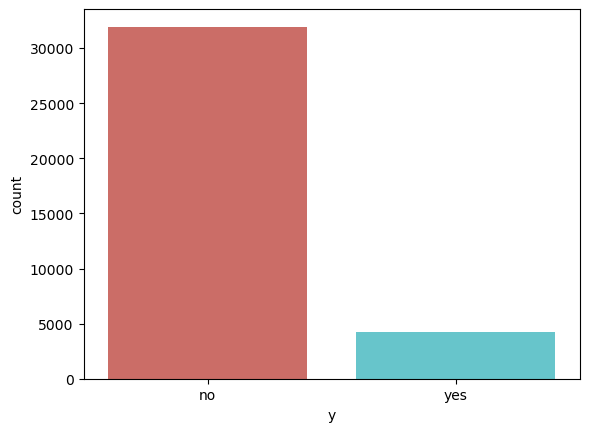

In [11]:
sns.countplot(x='y',data=df_train,palette='hls')
plt.show()

In [12]:
from sklearn.preprocessing import LabelEncoder
from imblearn.combine import SMOTETomek,SMOTEENN
from imblearn.over_sampling import KMeansSMOTE
from collections import Counter
from imblearn.over_sampling import SMOTE

d = {}
le = LabelEncoder()
categorical_columns = ['job','marital','education','default','housing','loan','contact','month','poutcome']
for col in categorical_columns:
    df_train[col] = le.fit_transform(df_train[col])
    d[col] = le.classes_
for col in categorical_columns:
    df_test[col] = le.fit_transform(df_test[col])
    d[col] = le.classes_
print('---')
smo = SMOTE(sampling_strategy={'yes': 6000, 'no': 31937},random_state=1)

label_mapping = {"no": 0, "yes": 1}

print(df_train)
X_smo, y_smo = smo.fit_resample(df_train.iloc[:,:-1], df_train.iloc[:,-1])
print(Counter(y_smo))
col_x = [i for i in df_train.columns if i not in ['y']]
x_train = X_smo
y_train = y_smo
x_test, y_test = df_test[col_x], df_test.y
print(y_train)
print(y_test)
y_test = y_test.map(label_mapping)
y_train = y_train.map(label_mapping)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(df_train.shape)


---
       age  job  marital  education  default  balance  housing  loan  contact  \
0       42    9        0          1        0      -78        1     1        0   
1       50    4        1          2        0      106        1     0        2   
2       47    0        1          1        0      407        1     0        2   
3       39    0        0          1        0      952        1     0        2   
4       30    4        2          2        0      364        0     0        0   
...    ...  ...      ...        ...      ...      ...      ...   ...      ...   
36163   30    4        2          2        0     1243        1     0        1   
36164   60    1        1          1        0      171        1     0        2   
36165   41    9        1          1        0     -274        1     0        2   
36166   45    1        1          0        0      103        0     0        0   
36167   40    3        1          1        0     4136        1     0        0   

       day  month  dura

/var/folders/pn/q7mmpvpx5n36lk_j6p9gqk4c0000gn/T/ipykernel_28241/1455371174.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_train.corr(),cbar=True,annot=True,cmap='Blues')


<Axes: >

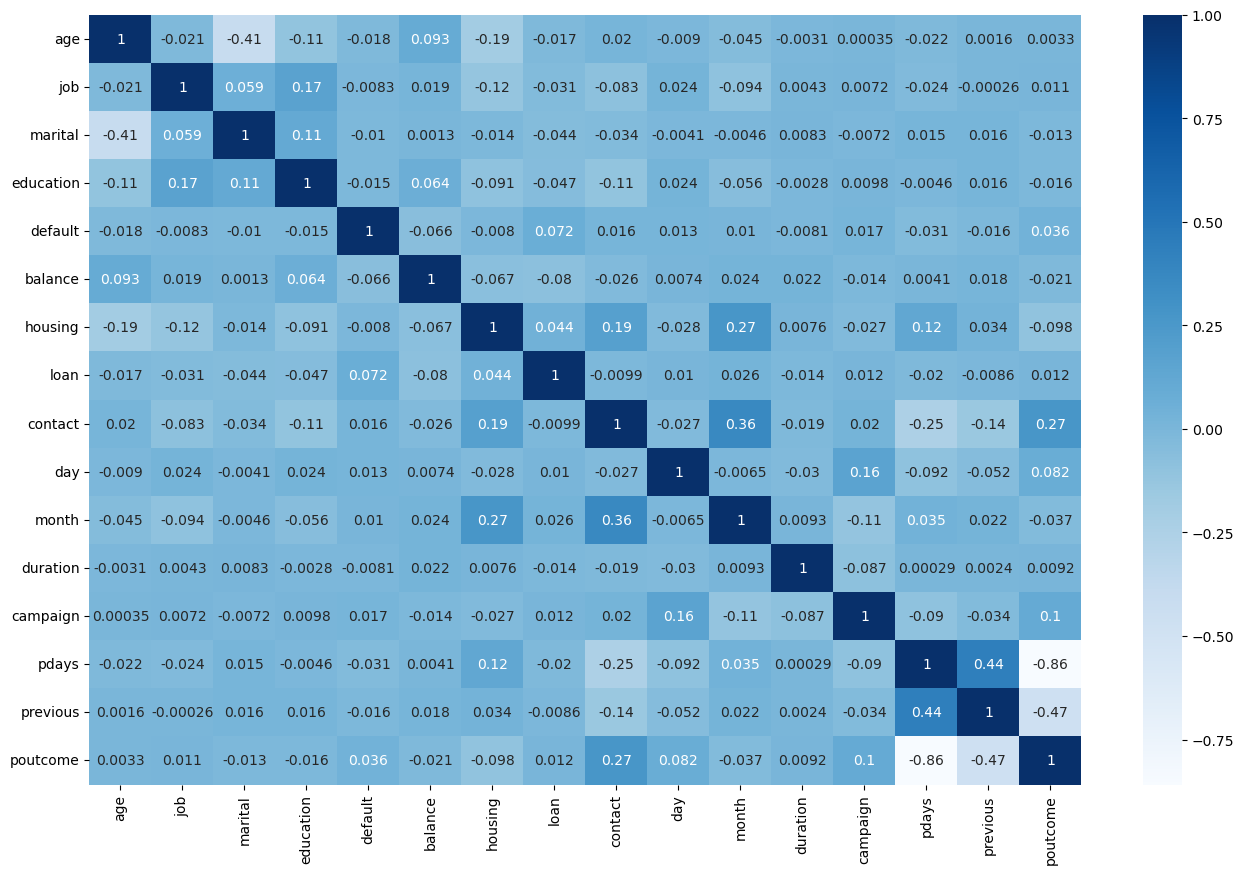

In [13]:
plt.figure(figsize=(16,10))
sns.heatmap(df_train.corr(),cbar=True,annot=True,cmap='Blues')

### Discover from above, the column 'pdays' and 'previous' have the highest correlation among input data label.

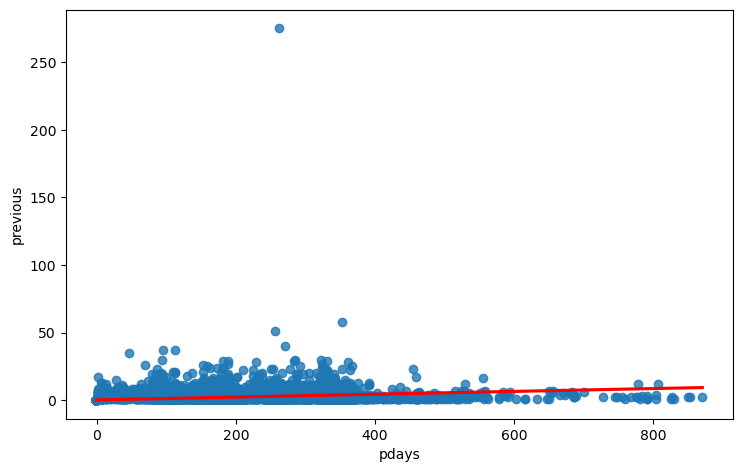

In [14]:
fig = plt.figure(figsize=(30, 50))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=1.9, wspace=0.3, hspace=0.5)
for i, col in enumerate(['pdays']):
    plt.subplot(15, 3, i + 1)
    sns.regplot(x=col, y="previous", data=df_train,line_kws={"color": "red"})
plt.show()

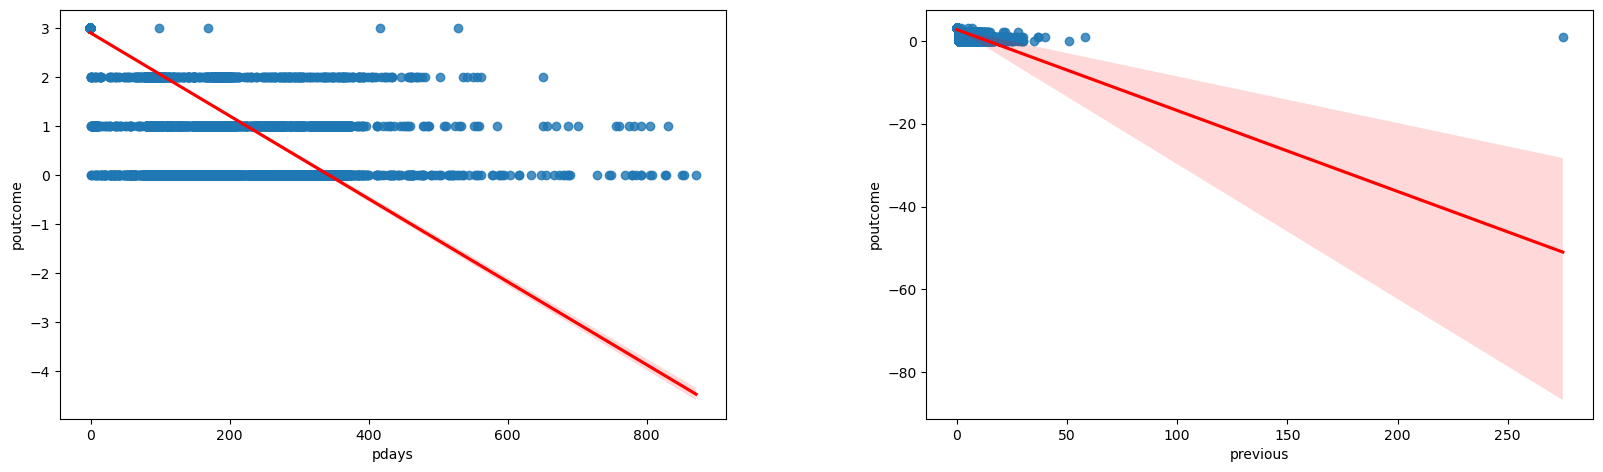

In [15]:
fig = plt.figure(figsize=(30, 50))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=1.9, wspace=0.3, hspace=0.5)
for i, col in enumerate(['pdays','previous']):
    plt.subplot(15, 3, i + 1)
    sns.regplot(x=col, y="poutcome", data=df_train,line_kws={"color": "red"})
plt.show()